# Assignment 3

In [1]:
import time
import tracemalloc
import heapq
from collections import defaultdict
import matplotlib.pyplot as plt
import json
import os

def profile_time_and_memory(func, *args, **kwargs):
    """Return a tuple: (result, elapsed_seconds, peak_kb)."""
    tracemalloc.start()
    start_snapshot = tracemalloc.take_snapshot()
    t0 = time.perf_counter()
    result = func(*args, **kwargs)
    t1 = time.perf_counter()
    end_snapshot = tracemalloc.take_snapshot()
    tracemalloc.stop()

    stats = end_snapshot.compare_to(start_snapshot, 'lineno')
    peak_bytes = sum(s.size_diff for s in stats if s.size_diff > 0)
    peak_kb = peak_bytes / 1024.0
    return result, (t1 - t0), peak_kb

## DEMO DATASETS

In [10]:
social = {
    'A': ['B', 'C'],
    'B': ['A', 'D', 'F'],
    'C': ['A', 'D', 'E'],
    'D': ['B', 'C'],
    'E': ['C'],
    'F': ['B']
}
edges_bf = [
    ('A', 'B', 4),
    ('A', 'C', 2),
    ('C', 'B', -1),
    ('B', 'D', 2),
    ('C', 'D', 3),
]
vertices_bf = ['A', 'B', 'C', 'D']

adj_dij = {
    'A': [('B', 1), ('C', 4)],
    'B': [('C', 2), ('D', 5)],
    'C': [('D', 1)],
    'D': []
}

prim_adj = {
    'A': [('B', 2), ('C', 3)],
    'B': [('A', 2), ('C', 1), ('D', 4)],
    'C': [('A', 3), ('B', 1), ('D', 5)],
    'D': [('B', 4), ('C', 5)]
}
edges_undirected = [
    ('A', 'B', 2),
    ('A', 'C', 3),
    ('B', 'C', 1),
    ('B', 'D', 4),
    ('C', 'D', 5)
]
vertices_undirected = ['A', 'B', 'C', 'D']

## Time and Space Complexity

In [17]:
def profile(func, *args, **kwargs):
    """Returns (result, time_taken_seconds, memory_kb)."""
    
    tracemalloc.start()
    start_snapshot = tracemalloc.take_snapshot()
    
    start_time = time.perf_counter()
    result = func(*args, **kwargs)
    end_time = time.perf_counter()
    
    end_snapshot = tracemalloc.take_snapshot()
    tracemalloc.stop()
    
    stats = end_snapshot.compare_to(start_snapshot, 'lineno')
    
    mem_kb = sum(s.size_diff for s in stats if s.size_diff > 0) / 1024
    return result, (end_time - start_time), mem_kb

## Problem 1: Social Friend Suggestion

In [18]:
def suggest_friends_mutual(graph, user, max_suggestions=5):
    if user not in graph:
        return []
    direct = set(graph[user])
    counts = defaultdict(int)
    for f in direct:
        for ff in graph.get(f, []):
            if ff == user or ff in direct:
                continue
            counts[ff] += 1
    candidates = sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))
    return candidates[:max_suggestions]

# Output
def suggest_friends(graph, user):
    direct = set(graph[user])
    mutuals = defaultdict(int)
    
    for friend in direct:
        for fof in graph.get(friend, []):
            if fof != user and fof not in direct:
                mutuals[fof] += 1
    
    return sorted(mutuals.items(), key=lambda x: (-x[1], x[0]))

result, t, mem = profile(suggest_friends, social, 'A')

print("Friend Suggestions:", result)
print(f"Time: {t:.8f}s")
print(f"Memory: {mem:.4f} KB")

Friend Suggestions: [('D', 2), ('E', 1), ('F', 1)]
Time: 0.00005590s
Memory: 0.6875 KB


## Problem 2: Route Finding On Google Maps

In [19]:
def bellman_ford(edges, vertices, source):
    dist = {v: float('inf') for v in vertices}
    if source not in dist:
        raise KeyError('source missing')
    dist[source] = 0
    V = len(vertices)
    for _ in range(V - 1):
        updated = False
        for u, v, w in edges:
            if dist[u] != float('inf') and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                updated = True
        if not updated:
            break
    for u, v, w in edges:
        if dist[u] != float('inf') and dist[u] + w < dist[v]:
            raise ValueError('Negative-weight cycle detected')
    return dist

# Output
def bellman_ford(edges, vertices, source):
    dist = {v: float('inf') for v in vertices}
    dist[source] = 0
    
    for _ in range(len(vertices) - 1):
        for u, v, w in edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
    return dist

result, t, mem = profile(bellman_ford, edges_bf, vertices_bf, 'A')

print("Bellman–Ford Distances:", result)
print(f"Time: {t:.8f}s")
print(f"Memory: {mem:.4f} KB")

Bellman–Ford Distances: {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Time: 0.00003700s
Memory: 0.5391 KB


## Problem 3: Emergency Response System

In [20]:
def dijkstra(adj, source):
    dist = {n: float('inf') for n in adj}
    if source not in dist:
        raise KeyError('source missing in adjacency')
    dist[source] = 0
    pq = [(0, source)]
    while pq:
        d, node = heapq.heappop(pq)
        if d > dist[node]:
            continue
        for nbr, w in adj.get(node, []):
            nd = d + w
            if nd < dist.get(nbr, float('inf')):
                dist[nbr] = nd
                heapq.heappush(pq, (nd, nbr))
    return dist

#Output
def dijkstra(adj, source):
    dist = {n: float('inf') for n in adj}
    dist[source] = 0
    pq = [(0, source)]
    
    while pq:
        d, node = heapq.heappop(pq)
        if d > dist[node]:
            continue
        
        for nbr, w in adj[node]:
            nd = d + w
            if nd < dist[nbr]:
                dist[nbr] = nd
                heapq.heappush(pq, (nd, nbr))
                
    return dist

result, t, mem = profile(dijkstra, adj_dij, 'A')

print("Dijkstra Distances:", result)
print(f"Time: {t:.8f}s")
print(f"Memory: {mem:.4f} KB")

Dijkstra Distances: {'A': 0, 'B': 1, 'C': 3, 'D': 4}
Time: 0.00005790s
Memory: 0.5078 KB


## Problem 4: Network Cable Installation

In [21]:
def prim_mst(adj):
    nodes = list(adj.keys())
    if not nodes:
        return 0, []
    start = nodes[0]
    visited = {start}
    pq = []
    for nbr, w in adj[start]:
        heapq.heappush(pq, (w, start, nbr))
    total = 0
    mst_edges = []
    while pq and len(visited) < len(adj):
        w, u, v = heapq.heappop(pq)
        if v in visited:
            continue
        visited.add(v)
        total += w
        mst_edges.append((u, v, w))
        for nbr, nw in adj[v]:
            if nbr not in visited:
                heapq.heappush(pq, (nw, v, nbr))
    if len(visited) != len(adj):
        raise ValueError('Graph disconnected; MST incomplete')
    return total, mst_edges

#Output
def prim_mst(graph):
    start = list(graph.keys())[0]
    visited = {start}
    pq = []
    
    for nbr, w in graph[start]:
        heapq.heappush(pq, (w, start, nbr))
        
    total = 0
    mst_edges = []
    
    while pq:
        w, u, v = heapq.heappop(pq)
        if v in visited:
            continue
        
        visited.add(v)
        total += w
        mst_edges.append((u, v, w))
        
        for nbr, nw in graph[v]:
            if nbr not in visited:
                heapq.heappush(pq, (nw, v, nbr))
    
    return total, mst_edges

(result_total, result_edges), t, mem = profile(prim_mst, prim_adj)

print("Prim MST Cost:", result_total)
print("Prim MST Edges:", result_edges)
print(f"Time: {t:.8f}s")
print(f"Memory: {mem:.4f} KB")

Prim MST Cost: 7
Prim MST Edges: [('A', 'B', 2), ('B', 'C', 1), ('B', 'D', 4)]
Time: 0.00004880s
Memory: 0.5625 KB


## Comparison

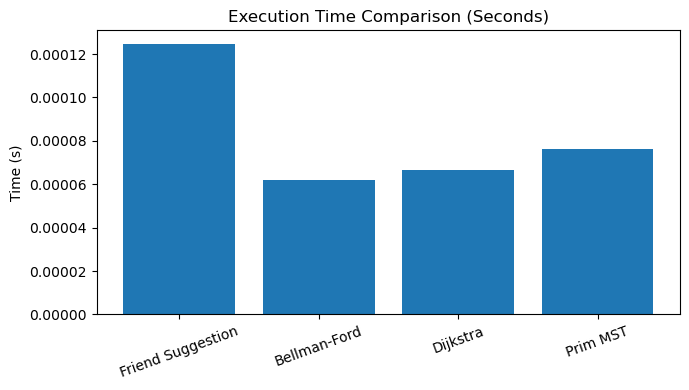

In [23]:
_, t1, _ = profile(suggest_friends, social, 'A')
_, t2, _ = profile(bellman_ford, edges_bf, vertices_bf, 'A')
_, t3, _ = profile(dijkstra, adj_dij, 'A')
(_, _), t4, _ = profile(prim_mst, prim_adj)

names = ["Friend Suggestion", "Bellman-Ford", "Dijkstra", "Prim MST"]
times = [t1, t2, t3, t4]

plt.figure(figsize=(7,4))
plt.bar(names, times)
plt.title("Execution Time Comparison (Seconds)")
plt.ylabel("Time (s)")
plt.xticks(rotation=20)
plt.tight_layout()

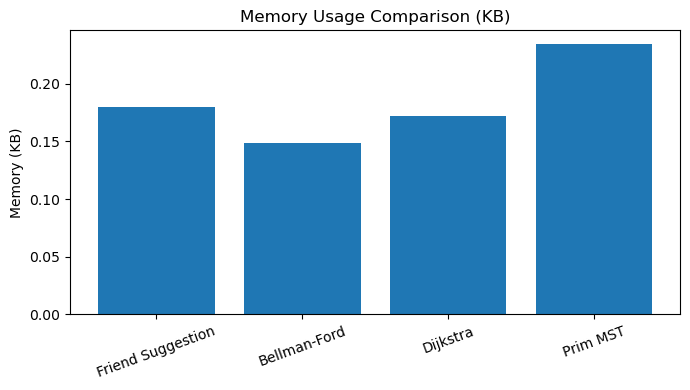

In [25]:
_, _, mem1 = profile(suggest_friends, social, 'A')
_, _, mem2 = profile(bellman_ford, edges_bf, vertices_bf, 'A')
_, _, mem3 = profile(dijkstra, adj_dij, 'A')
(_, _), _, mem4 = profile(prim_mst, prim_adj)

names = ["Friend Suggestion", "Bellman-Ford", "Dijkstra", "Prim MST"]
mems = [mem1, mem2, mem3, mem4]

plt.figure(figsize=(7,4))
plt.bar(names, mems)
plt.title("Memory Usage Comparison (KB)")
plt.ylabel("Memory (KB)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()